# Improvements to models

We attempt to modify the model in the following ways:  

1.  Generalizing to a second order model  (first order for leaders/predators and second order for followers/prey)  

2. Adding perception cones of individuals 

3. Change the area of effect of other individuals: the interaction force is no longer averaged over the entire population but over $k$ nearest neighbours

## 1 A second order model  

The following is a second order model (first order for the predator)

$$
\begin{equation}
    \begin{cases}
        \dot{x}_j = v_j\\[2ex]
        \dot{v}_j = \dfrac1N \sum\limits_{k=1}^N  \bigg\{\dfrac{\kappa_h(v_k-v_j)}{(\zeta_h ^2 + \|x_j-x_k\|^2)^{\gamma_h}} - a(x_j-x_k) + b_1\dfrac{x_j-x_k}{\|x_j-x_k\|^2}\bigg\} + {\color{red}b_2\dfrac{x_j-z}{\|x_j-z\|^2}} \\[5ex]
        \dot{z} = \dfrac{1}{N} \sum\limits_{k=1}^N  c\dfrac{x_k-z}{\|x_k-z\|^p}
    \end{cases}
\end{equation}
$$  

For the moment $\zeta=\gamma=1$ for both the prey and predator, while the parameters $a,b_1, b_2, c, p$ can be tuned.  
It might be better if the summation above was taken to exclude the $j^{th}$ prey.  

An observation is that larger $p$ will lead to predators moving away (inversely proportional to distance)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from solvers.rk_solvers import *
from models import *
from solvers.euler import *
from helper import *

### Case 1

A stable state $\kappa_h = 0.5, a=1, b_1 = 1, b_2 = 0.07, c = 10 ,p = 1.2$  

In [27]:
N = 100

case1  = computeSoln(model1, 
    {'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 1, 
    'repulsion of prey b_1': 1, 
    'repulsion of pred b_2': 0.07, 
    'attraction of pred c': 10, 
    'exponent of dist pred p': 1.2},
    1000,
    (0,20),
    False,
    'random',
    'rk2',
    [i*2  for i in range(10)],
    12)

No. of time steps: 1000


100%|██████████| 999/999 [00:08<00:00, 112.98it/s]


In [25]:
# to change the time
# case1[2] = [i for i in range(20)]

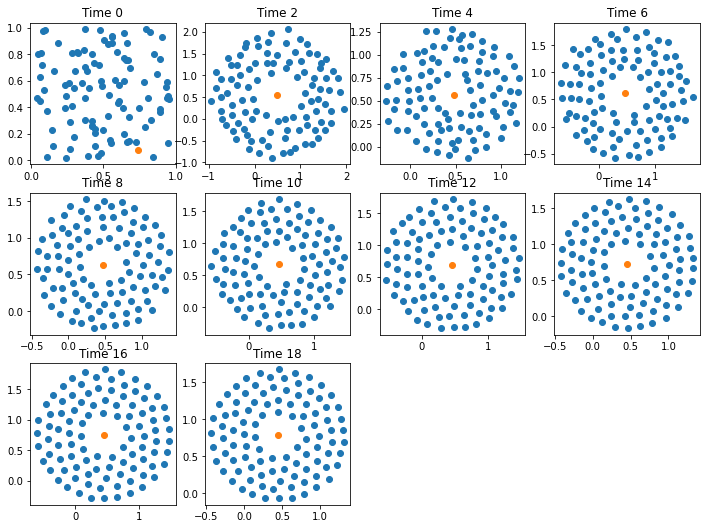

In [28]:
multiPlot(case1, None, True)

### Case 2

A  state where the predator drives the prey into a cluster $\kappa_h = 0.5, a=1, b_1 = 1, b_2 = 0.07, c = 1.5 ,p = 1.2$  

In [5]:
N = 400

case2  = computeSoln(model1, 
    {'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 1, 
    'repulsion of prey b_1': 1, 
    'repulsion of pred b_2': 0.07, 
    'attraction of pred c': 1.5, 
    'exponent of dist pred p': 1.2},
    1000,
    (0,100),
    False,
    'random',
    'rk2',
    [i*10  for i in range(10)],
    12)

No. of time steps: 1000


100%|██████████| 999/999 [01:26<00:00, 11.54it/s]


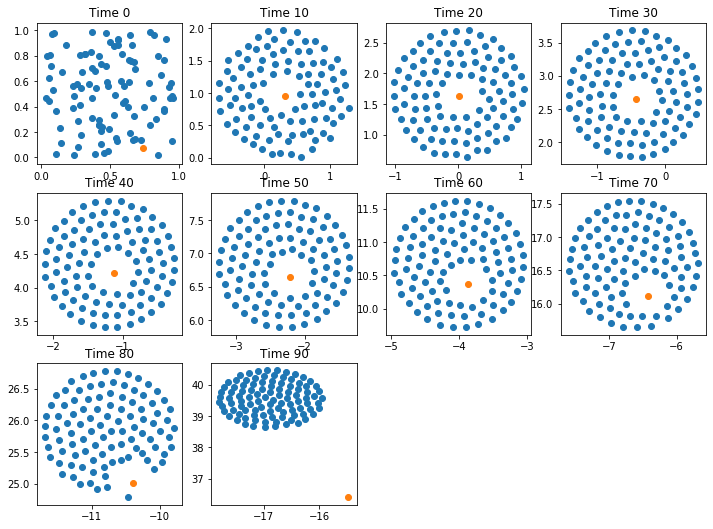

In [3]:
multiPlot(case2, None, True)

### Case 3

A state where the predator is more active and prey experiencing greater repulsion with  $\kappa_h = 0.5, a=0, b_1 = 0.15, b_2 = 0.15, c = 10 ,p = 3$

In [22]:
N = 100

case3  = computeSoln(model1, 
    {'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 0, 
    'repulsion of prey b_1': 0.15, 
    'repulsion of pred b_2': 0.15, 
    'attraction of pred c': 10, 
    'exponent of dist pred p': 3},
    1000,
    (0,200),
    False,
    'random',
    'rk2',
    [i*10  for i in range(10)],
    12)

No. of time steps: 1000


100%|██████████| 999/999 [00:07<00:00, 132.03it/s]


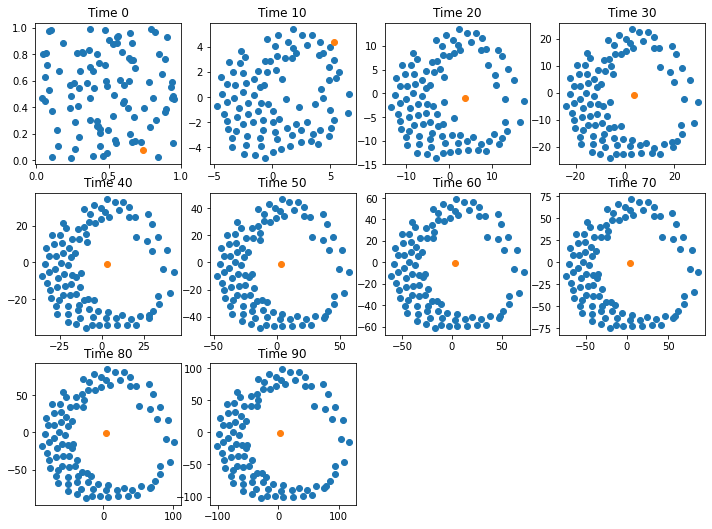

In [23]:
multiPlot(case3, None, True)

## 2 Adding the perception cones  

This is the same model but each individual of the prey can only react to the changes within their perceptioin cones.  

$$
\begin{equation}
    \begin{cases}
        \dot{x}_j = v_j\\[2ex]
        \dot{v}_j = \dfrac1N \sum\limits_{k=1}^N  \psi_\alpha(x_k,x_j,v_k) \bigg\{\dfrac{\kappa_h(v_k-v_j)}{(\zeta_h ^2 + \|x_j-x_k\|^2)^{\gamma_h}} - a(x_j-x_k) + b_1\dfrac{x_j-x_k}{\|x_j-x_k\|^2}\bigg\} + {\color{red}b_2\dfrac{x_j-z}{\|x_j-z\|^2} \psi_\alpha(x_k,z,v_k)} \\[5ex]  
        \dot{z} = \dfrac{1}{N} \sum\limits_{k=1}^N  \bigg\{c\dfrac{x_k-z}{\|x_k-z\|^p} \bigg\} \psi_\alpha(z,x_k,\dot{z})
    \end{cases}
\end{equation}
$$  

where the perception cone for the $i^{th}$ prey is given by  

$$
\begin{equation}
        \Sigma(x_i, v_i, \theta) = \left\{ y \in \mathbb{R^d}: \frac{(x_i-y) \cdot v_i}{|x_i-y||v_i|} \geq \cos(\theta/2) \right\}
\end{equation}  
$$  
The perception is computed by  
$$
\begin{equation}
        \psi_{\alpha} (x_i, x_j, v_i) = p_2 + (p_1-p_2) \mathbf{1}_{\Sigma(x_i, v_i, \theta)}
\end{equation} 
$$
and $\alpha = (\theta, p_1, p_2)$ is the parameter vector with $p_1,p_2 \in [0,1]$

In [103]:
def model3(y, params):
  '''
  Returns ndarray of shape (dim, 2) containing the derivatives.   
  
  Input:   
    - y: an array containing the following inputs   
      - pprey: ndarray of (N,2), the positions of the prey  
      - vprey: ndarray of (N,2), the velocities of the prey  
      - ppred: ndarray of (1,2), the positions of the predator  

    - params: py dict, extra parameters for the model (N, kh, a, b1, b2, p1, p2, angle, c, p) for now

  Returns:   
    - dy: ndarray of (2*N+1, 2), the derivatives of the inputs  
  '''  

  # unpacking parameters
  N, kh, a, b1, b2, p1, p2, angle, c, p = params.values()
  # N, kh, a, b1, b2, c, p = params.values() 

  pprey = y[0:N]  
  vprey = y[N:2*N]  
  ppred = y[2*N:]
  # vpred = y[2*N+1:]  

  # ndarrays of shape (N, N-1, 2)
  dist_prey =  np.array([pprey[i] - np.delete(pprey, i, axis = 0) for i in range(N)])  
  
  vel_prey  =  np.array([vprey[i] - np.delete(vprey, i, axis = 0) for i in range(N)])  

  # perception cone for prey observing prey
  _vprey = vprey[:,np.newaxis,:] + np.zeros_like(dist_prey)
  dot_prod = np.sum(_vprey*dist_prey, axis = 2)[:,:,np.newaxis]
  norm_prey = np.linalg.norm(dist_prey, axis = 2)[:,:,np.newaxis]
  abs_val  = np.linalg.norm(_vprey, axis=2)[:,:,np.newaxis] * norm_prey
  mask_hh = (dot_prod / abs_val)>=angle # (N,N-1,1)
  
  # kernel of prey
  ker_prey = -1 * kh * vel_prey / (1 + (norm_prey**2))
  
  # attraction of prey
  attrac_prey = -1 * a * dist_prey

  # repulsion of prey
  rep_prey = b1 * dist_prey / (norm_prey**2)
                          
  # repulsion of predator (N,2)
  norm_pred = np.linalg.norm(pprey - ppred, axis = 1)[:,np.newaxis]
  rep_pred = b2 * (pprey - ppred) / (norm_pred**2)  
  
  # perception cone for prey observing predator (N,1)
  mask_hp = (np.sum(vprey*(pprey-ppred), axis = 1)[:,np.newaxis] / (norm_pred * np.linalg.norm(vprey)))>=angle
  
  # acceleration of prey
  acc_prey = (1/N) * np.sum((p2 + mask_hh * (p1-p2)) * (ker_prey + attrac_prey + rep_prey), axis=1) + \
    rep_pred * mask_hp  

  # perception cone for predator observing prey 
  

  # velocity of predator
  vpred = (1/N) * (c * np.sum((pprey - ppred) / (norm_pred**p), 
                                 axis = 0))[np.newaxis]
                                 
  return np.concatenate((vprey, acc_prey, vpred))
  

$\kappa_h = 0.5, a=1, b_1 = 1, b_2 = 0.07, c = 10 ,p = 1.2$  

In [105]:
N = 100

case4  = computeSoln(model3, 
    {'no. of prey': N, 
    'kappa for prey': 0.5, 
    'attraction of prey a': 0, 
    'repulsion of prey b_1': 0.15, 
    'repulsion of pred b_2': 0.30,
    'p1 spotted': 0.8,
    'p2 not spotted':0.4,
    'angle': np.cos(np.pi / 3), 
    'attraction of pred c': 10, 
    'exponent of dist pred p': 3},
    1000,
    (0,200),
    False,
    'random',
    'rk4',
    [i*10  for i in range(20)],
    15)

No. of time steps: 1000


  0%|          | 0/999 [00:00<?, ?it/s]C:\Users\yunjie wang\AppData\Local\Temp\ipykernel_10612\2661961140.py:36: RuntimeWarning: invalid value encountered in true_divide
  mask_hh = (dot_prod / abs_val)>=angle # (N,N-1,1)
C:\Users\yunjie wang\AppData\Local\Temp\ipykernel_10612\2661961140.py:52: RuntimeWarning: invalid value encountered in true_divide
  mask_hp = (np.sum(vprey*(pprey-ppred), axis = 1)[:,np.newaxis] / (norm_pred * np.linalg.norm(vprey)))>=angle
100%|██████████| 999/999 [00:13<00:00, 74.09it/s]


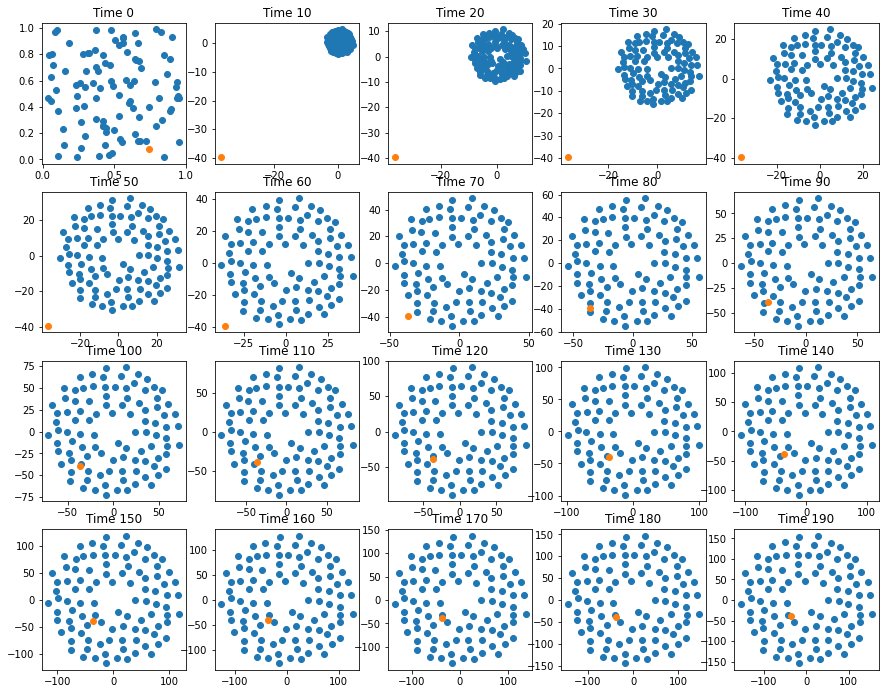

In [106]:
multiPlot(case4, None, True)

## 3 Adding topological effect  

Finally we consider the nearest neighbours' effect on each prey.